### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import GMM, MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengersDF as Y_df
from ray import tune

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set and split data into **train** and **test**

In [ ]:

from neuralforecast.utils import AirPassengersDF as Y_df
# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train data
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test data
#dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)

Lets initialize and training model (**LSTM**) and define its
hyperparameters.

In [ ]:
horizon = 12
fcst = NeuralForecast(
    models=[LSTM(h=horizon, input_size=-1,
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=200,
                 #futr_exog_list=['y_[lag12]'],
                 #hist_exog_list=['y_[lag12]'],
                 #stat_exog_list=['airline1'],
                 )
    ],
    freq='M'
)
fcst.fit(df =Y_train_df)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | loss            | DistributionLoss | 5      | train
1 | padder          | ConstantPad1d    | 0      | train
2 | scaler          | TemporalNorm     | 0      | train
3 | hist_encoder    | LSTM             | 199 K  | train
4 | context_adapter | Linear           | 15.5 K | train
5 | mlp_decoder     | MLP              | 1.7 K  | train
-------------------------------------------------------------
216 K     Trainable params
5         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


In [ ]:
model.fit(dataset=dataset)

+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-07-24_21-32-44   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 1                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-07-24_21-32-44
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-07-24_21-32-07_599908_347/artifacts/2024-07-24_21-32-44/_train_tune_2024-07-24_21-32-44/driver_artifacts`


(_train_tune pid=2912) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=2912) Seed set to 1
(_train_tune pid=2912) GPU available: False, used: False
(_train_tune pid=2912) TPU available: False, using: 0 TPU cores
(_train_tune pid=2912) HPU available: False, using: 0 HPUs
(_train_tune pid=2912) Missing logger folder: /tmp/ray/session_2024-07-24_21-32-07_599908_347/artifacts/2024-07-24_21-32-44/_train_tune_2024-07-24_21-32-44/working_dirs/_train_tune_adee1_00000_0_input_size=24_2024-07-24_21-32-44/lightning_logs
(_train_tune pid=2912) 2024-07-24 21:32:54.887282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(_train_tune pid=2912) 2024-07-24 21:

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 48.32it/s, v_num=0, train_loss_step=0.358, train_loss_epoch=0.424]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 192:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.891, train_loss_epoch=0.891, valid_loss=55.80]


2024-07-24 21:33:05,408	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-07-24_21-32-44' in 0.0070s.
(_train_tune pid=2912) `Trainer.fit` stopped: `max_steps=200` reached.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s, v_num=0, train_loss_step=0.519, train_loss_epoch=0.314, valid_loss=55.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s, v_num=0, train_loss_step=0.519, train_loss_epoch=0.519, valid_loss=60.90]



INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | eval 
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 321 K  | train
4 | context_adapter | Linear                     | 24.1 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.392     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


AutoTCN

Predict for the next defined horizon

In [ ]:
y_hat = fcst.predict()
y_hat.set_index('ds',inplace =True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
y_hat

,LSTM,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90
ds,,,,,,
1960-01-31,350.888092,350.775146,295.248077,305.006714,396.771301,410.420013
1960-02-29,363.306000,363.748505,323.620117,330.534210,396.106293,407.590698
1960-03-31,390.778564,390.904602,339.590057,350.849121,432.370148,445.618408
1960-04-30,424.257782,423.604706,372.827545,383.003418,464.217773,476.210663
1960-05-31,449.194122,450.273926,397.561066,412.049072,484.153259,494.906708
1960-06-30,473.402252,473.729187,415.734924,430.352264,517.406128,530.791321
1960-07-31,518.990356,518.098511,473.672150,482.470825,555.480591,568.247498
1960-08-31,551.031250,549.679626,501.200378,511.532898,592.827454,603.680420
1960-09-30,556.499207,556.382935,513.862061,524.220215,587.874756,598.466736


Measure the models accuracy

In [ ]:
calculate_error_metrics(Y_test_df[['y']],y_hat[['LSTM']])

MSE : 2924.734375
RMSE : 54.080814361572266
MAPE : 0.10070467740297318
r2 : 0.47201929308164103
adjusted_r2 : 0.4192212223898052


Visualize the predictions

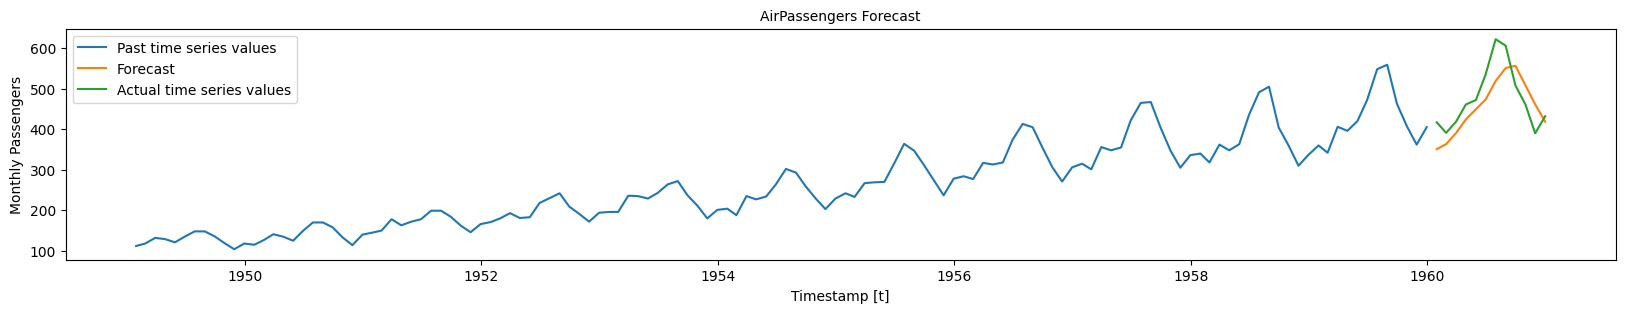

In [ ]:
Y_train_df.set_index('ds',inplace =True)
#y_hat.set_index('ds',inplace =True)
Y_test_df.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

y_past = Y_train_df["y"]
y_pred = y_hat[['LSTM']]
y_test = Y_test_df["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();